In [1]:
from pyrates.utility import plot_timeseries, grid_search, plot_psd, plot_connectivity, create_cmap, adapt_circuit
from pyrates.frontend import CircuitTemplate
from pyrates.backend import ComputeGraph
import numpy as np
import matplotlib.pyplot as plt

Extended Montbrio neural population models: Documentation of the model configuration and state space exploration
==================================

In this chapter, we define and analyze the neural population model that will form the basis of all subsequently described neural circuit models. At the core of this model lies the population model developed by Montbrio and colleagues (2015). This poses a mathematically exact mean-field description of the macroscopic state of a globally coupled quadratic integrate-and-fire population. The dynamics of its average membrane potential $v$ and average firing rate $r$ follow:

$$\dot{r} = \frac{\Delta}{\pi \tau^2} + \frac{2 r v}{\tau}$$

$$\dot{v} = \frac{v^2 + \overline{\eta} + I(t)}{\tau} + J r - \tau \pi^2 r^2$$

Where $\tau$ is the lumped time-constant of the membrane, $J$ is a coupling constant, $I$ is an extrinsic input current and $\overline{\eta}$ and $\Delta$ are parameters of a Lorentzian probability distribution describing the distribution of firing thresholds in the neural population. As shown by Montbrio and colleagues (2015), the steady-state population dynamics resulting from this description critically depend on the parameters $J$ and $\overline{\eta}$. Given the choice of $J$ and $\overline{\eta}$, the phase portrait spanned by $r$ and $v$ either contains a single or two attractors (a stable node, a stable focus or both). In the following sections, we will extend the Montbrio model via synaptic integration and short-term adaptation mechanisms and analyze the influence of these mechanisms on the model behavior. 


I: Parameter space exploration of the basic Montbrio model
-------------------------------------------------------------------------------------

In a first step, we look at the membrane potential and firing rate dynamics for constant and oscillatory extrinsic input applied to a single base Montbrio population (without any extensions) for increasing input strengths. This is done separately for an excitatory and an inhibitory population. Based on the the parametrization reported in Montbrio et al. (2015), we used the following initial set of parameters:

$\tau = 0.02 s$

$J = 15.0$

$\Delta = 1.0$

$\eta = -5.0$

**Parameter definition:**

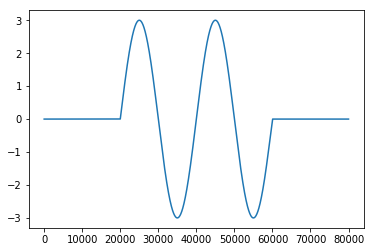

In [4]:
# general parameters
dt = np.round(5e-5, decimals=6)
T = 4.

# input parameters
mu = 3.
input_start = int(1./dt)
input_end = int((T-1.)/dt)
input_constant = np.zeros((int(T/dt), 1))
input_constant[input_start:input_end] = mu
input_oscillatory = np.zeros_like(input_constant)
input_oscillatory[input_start:input_end, 0] = 3. * np.sin(np.pi * dt * 2. * np.arange(input_start, input_end, 1))

plt.plot(input_oscillatory)

**Model definition:**

In [34]:
# define the models via a yaml template
net_config = CircuitTemplate.from_yaml("../config/cmc_templates.EI_base").apply()

# load the template into a compute graph
net = ComputeGraph(net_config, vectorization='full', dt=dt)

**Simulations:**

In [35]:
results_const = net.run(T, inputs={("E", "Op_e_base.0", "i_in"): input_constant,
                                   ("I", "Op_i_base.0", "i_in"): input_constant}, 
                        outputs={"r_e": ("E", "Op_e_base.0", "r"),
                                 "r_i": ("I", "Op_i_base.0", "r")},
                        sampling_step_size=1e-3)

results_oscil = net.run(T, inputs={("E", "Op_e_base.0", "i_in"): input_oscillatory,
                                   ("I", "Op_i_base.0", "i_in"): input_oscillatory}, 
                        outputs={"r_e": ("E", "Op_e_base.0", "r"),
                                 "r_i": ("I", "Op_i_base.0", "r")},
                        sampling_step_size=1e-3)

**Visualization:**

Text(0.5, 1.0, 'I: oscillatory')

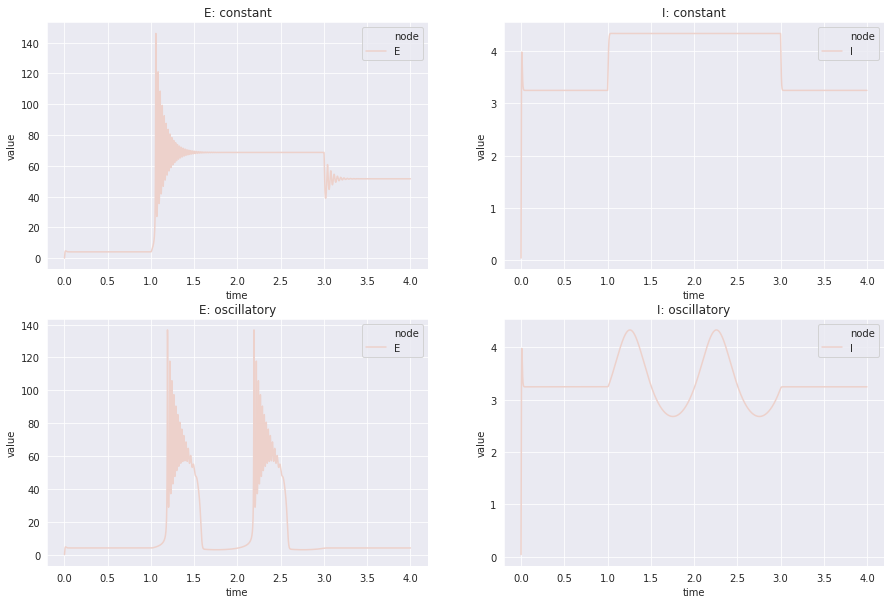

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes[0, 0] = plot_timeseries(results_const['r_e'], ax=axes[0, 0])
axes[0, 0].set_title('E: constant')
axes[0, 1] = plot_timeseries(results_const['r_i'], ax=axes[0, 1])
axes[0, 1].set_title('I: constant')
axes[1, 0] = plot_timeseries(results_oscil['r_e'], ax=axes[1, 0])
axes[1, 0].set_title('E: oscillatory')
axes[1, 1] = plot_timeseries(results_oscil['r_i'], ax=axes[1, 1])
axes[1, 1].set_title('I: oscillatory')

II: Adding short-term firing rate adaptation to the Montbrio model
---------------------------------------------------------------------------------------------

This model is extended by plasticity mechanism that adjusts the coupling constant $J$ based on the current firing rate $r$. In particular, the evolution of $J$ is described by:

$$J' = J_0 - J$$

$$\dot{J} = a$$

$$\dot{a} = \frac{\alpha}{\tau_a} r - \frac{2a}{\tau_a} - \frac{J}{\tau_a^2}$$

Where $J_0$ represents the baseline coupling constant, $\alpha$ the scaling of the firing rate and $\tau_a$ the adaptation time-scale. To add this mechanism the Montbrio model, we substituted $J$ with $J'$. 

In the following, we will investigate the effect of this adaptation mechanism on the model behavior for different choices of $\alpha$ and $\tau_a$. First, we look at the raw firing rate dynamics for different choices of $\tau_a$ given $\alpha = 100.0$, $J_0 = 15.0$, $\eta = -5$ and $\Delta = 1.0$.

**Sweep over $\tau_a$: Parameter definition:**

In [5]:
tau_a = np.round(np.arange(0.05, 1., 0.05), decimals=4)
param_map = {'tau_a': {'var': [('Op_e_adapt.0', 'tau_a'), ('Op_i_adapt.0', 'tau_a')],
                       'nodes': ['E.0', 'I.0']},
             }

**Sweep over $\tau_{a}$: Simulation**

In [6]:
results = grid_search(circuit_template="../config/cmc_templates.EI_adapt",
                      param_grid={'tau_a': tau_a}, param_map=param_map,
                      inputs={("I", "Op_i_adapt.0", "i_in"): input_constant}, 
                      outputs={"r": ("I", "Op_i_adapt.0", "r")},
                      dt=dt, simulation_time=T, permute_grid=False, sampling_step_size=1e-3)

**Sweep over $\tau_{a}$: Visualization:**

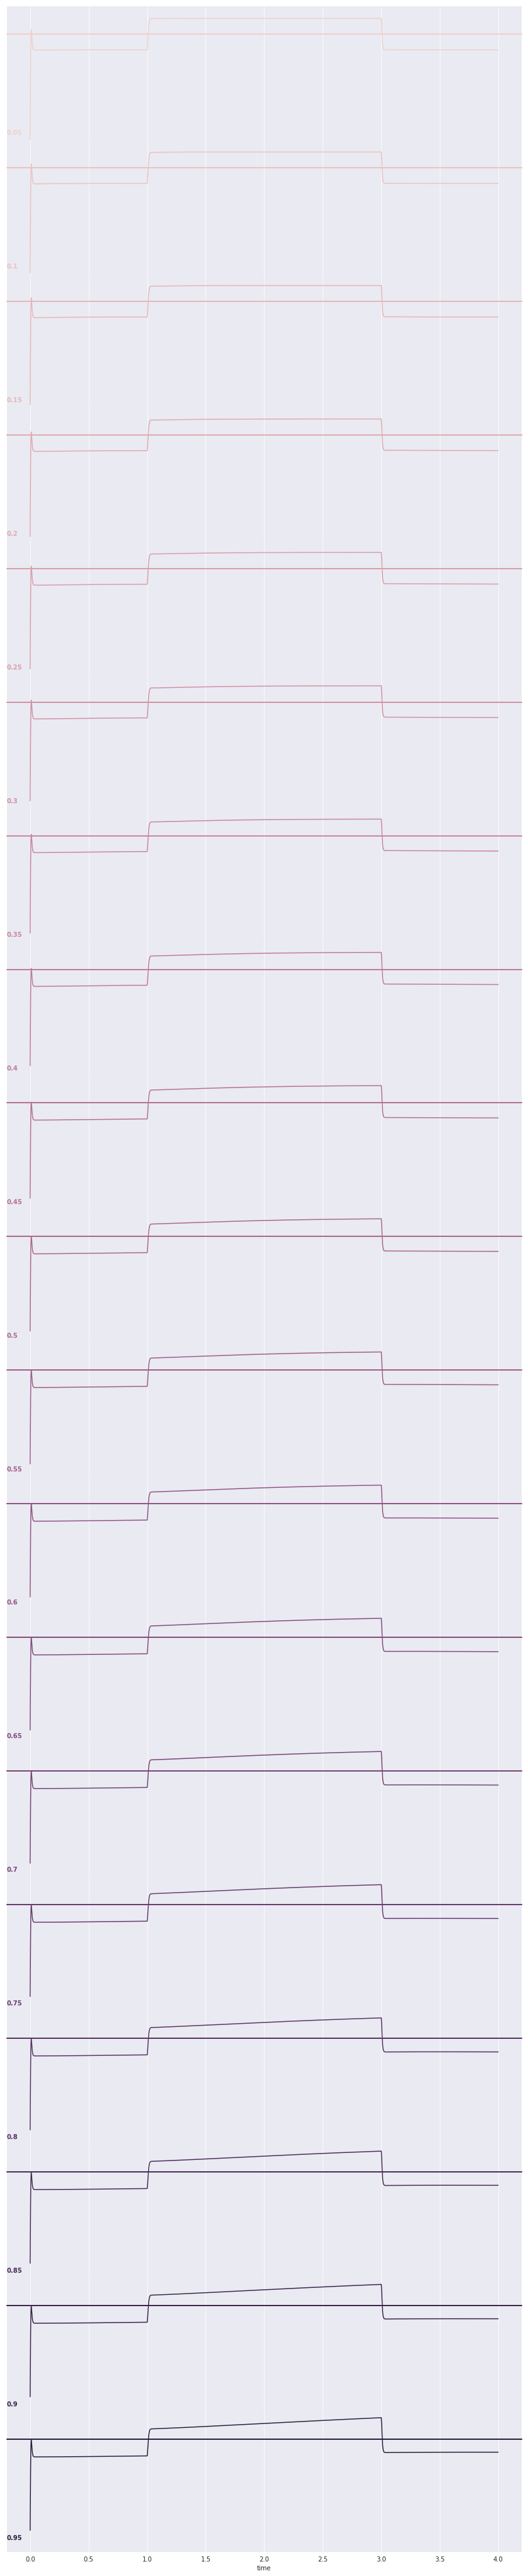

In [7]:
plot_timeseries(results, plot_style='ridge_plot', demean=True, aspect=4.0)

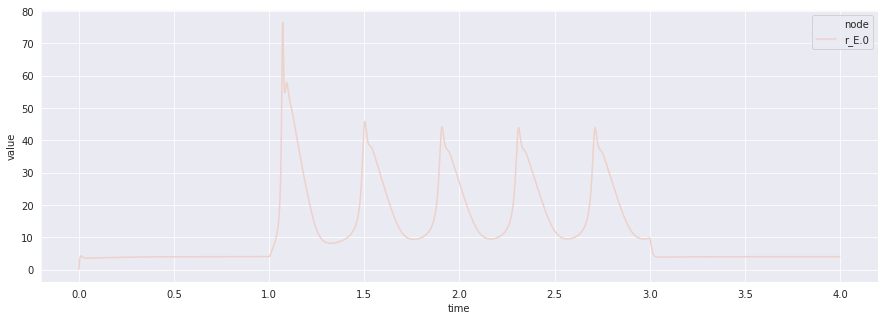

In [10]:
idx = 1
fig, ax = plt.subplots(figsize=(15,5))
plot_timeseries(results[tau_a[idx]], ax=ax)

Next, we investigate the model dynamics for different adaptation rates $\alpha$ with $\tau_a = 0.1$, $J_0 = 15.0$, $\eta = -5$ and $\Delta = 1.0$.

**Sweep over $\alpha$: Parameter definition:**

In [8]:
alpha = np.round(np.asarray([0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56, 5.12]), decimals=3)
param_map = {'alpha': {'var': [('Op_e_adapt.0', 'alpha'), ('Op_i_adapt.0', 'alpha')],
                       'nodes': ['E.0', 'I.0']}}

**Sweep over $\alpha$: Simulation:**

In [9]:
results = grid_search(circuit_template="../config/cmc_templates.EI_adapt",
                      param_grid={'alpha': alpha}, param_map=param_map,
                      inputs={("E", "Op_e_adapt.0", "i_in"): input_constant, 
                              ("I", "Op_i_adapt.0", "i_in"): input_constant}, 
                      outputs={"r": ("I", "Op_i_adapt.0", "r")},
                      dt=dt, simulation_time=T, permute_grid=False, sampling_step_size=1e-3)

**Sweep over $\alpha$: Visualization:**

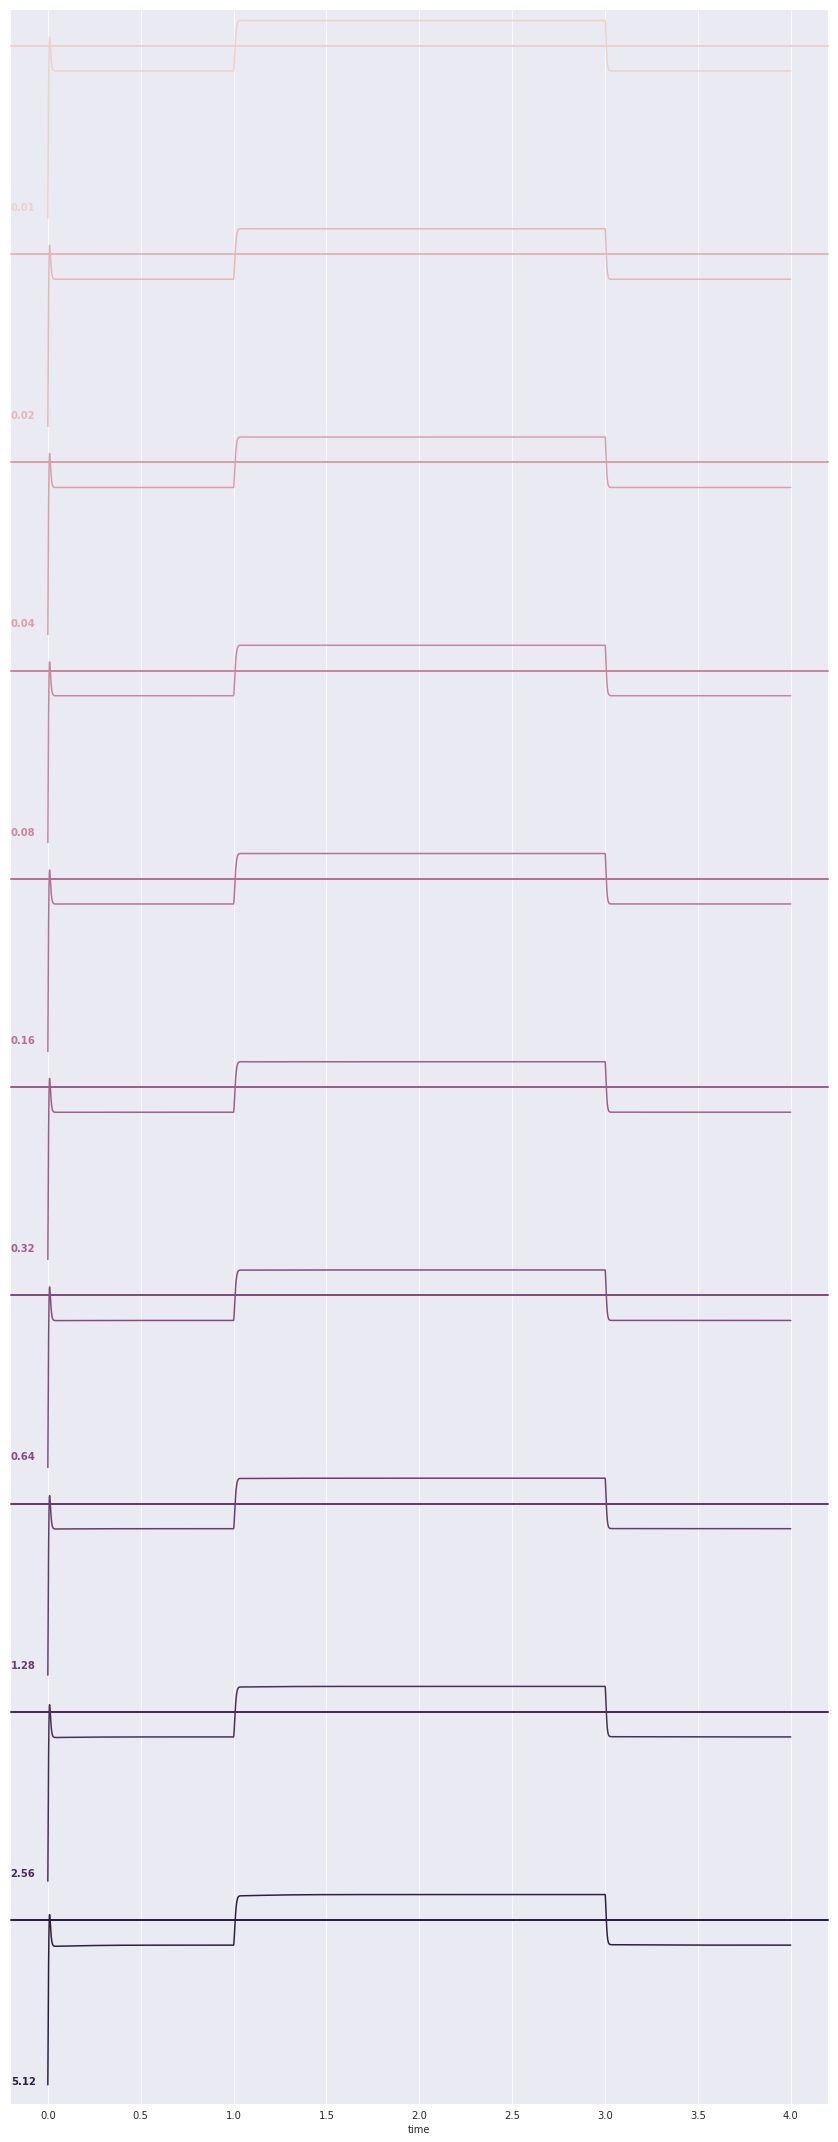

In [10]:
plot_timeseries(results, plot_style='ridge_plot', demean=True, aspect=4.0)

/home/rgast/PycharmProjects/PyRates/pyrates/utility/visualization.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['time'] = data.index


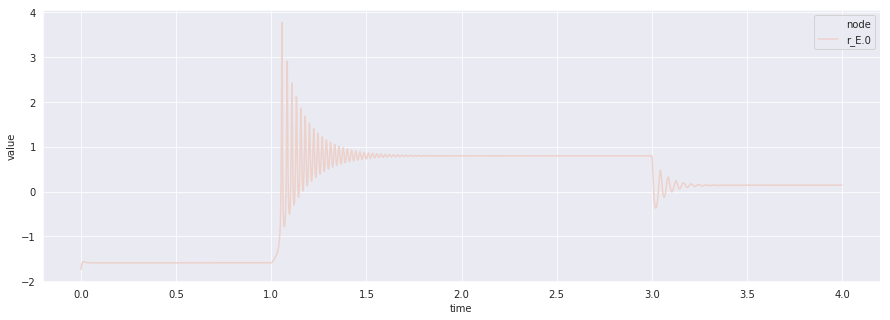

In [19]:
idx = 1
fig, ax = plt.subplots(figsize=(15,5))
plot_timeseries(results[alpha[idx]], ax=ax)

Next, we investigate the model dynamics for different coupling strengths $J_0$ with $\alpha = 3.0$, $\tau_a = 0.1$, $\eta = -5$ and $\Delta = 1.0$.

**Sweep over $J_0$: Parameter definition:**

In [10]:
J_0 = np.round(np.arange(10., 20., 0.5), decimals=1)
param_map = {'J_0': {'var': [('Op_e_adapt.0', 'J_0'), ('Op_i_adapt.0', 'J_0')],
                     'nodes': ['E.0', 'I.0']}}

**Sweep over $J$: Simulation:**

In [11]:
results = grid_search(circuit_template="../config/cmc_templates.EI_adapt",
                      param_grid={'J_0': J_0}, param_map=param_map,
                      inputs={("E", "Op_e_adapt.0", "i_in"): input_constant, 
                              ("I", "Op_i_adapt.0", "i_in"): input_constant}, 
                      outputs={"r": ("E", "Op_e_adapt.0", "r")},
                      dt=dt, simulation_time=T, permute_grid=False, sampling_step_size=1e-3)

**Sweep over $J$: Visualization:**

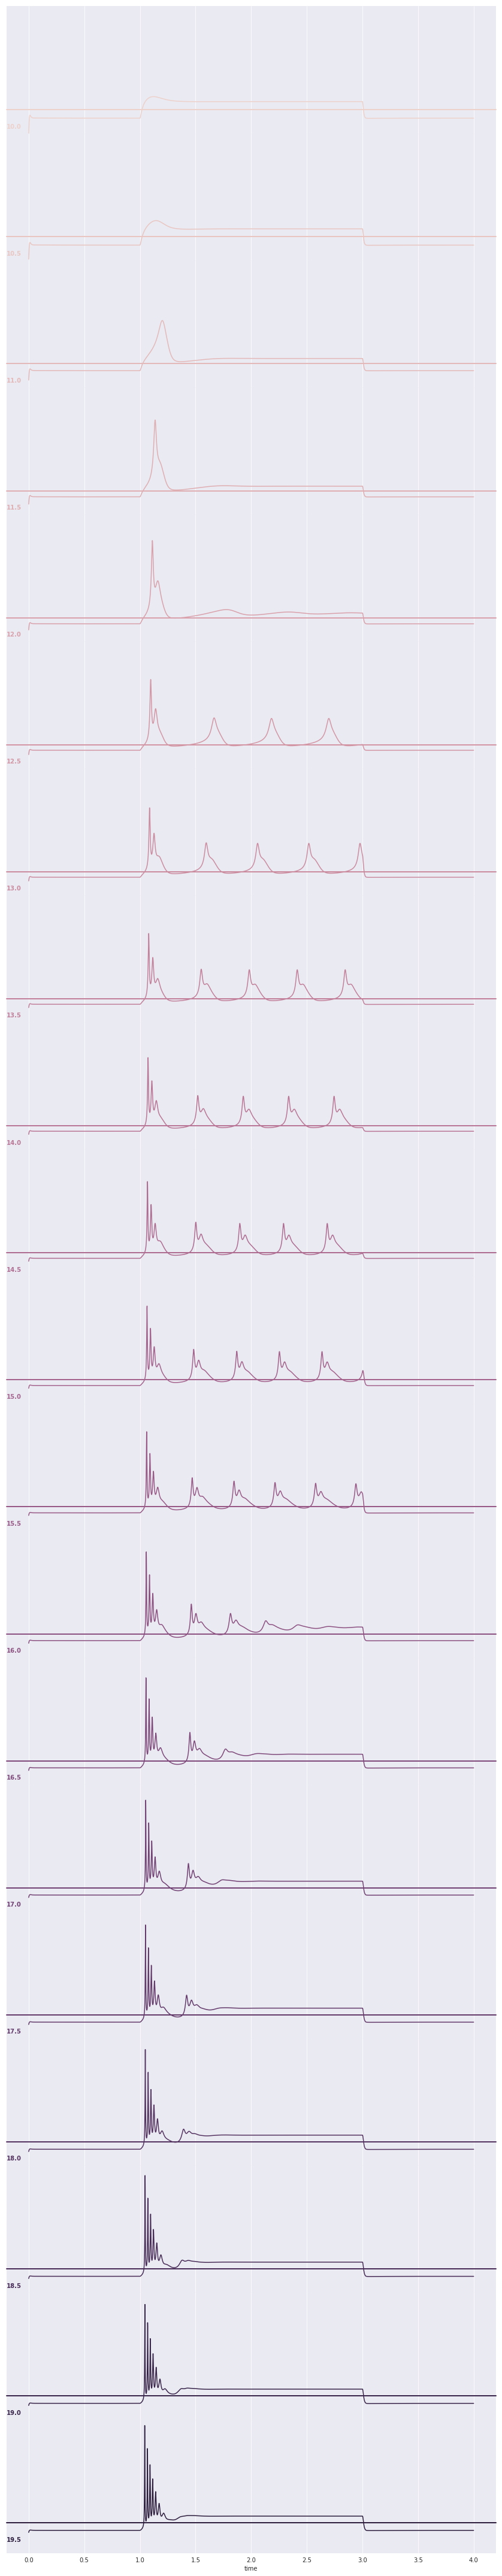

In [12]:
plot_timeseries(results, plot_style='ridge_plot', demean=True, aspect=4.0)

Next, we investigate the model dynamics for different spreads of background excitation  $\Delta$ with $\alpha = 3.0$, $\tau_a = 0.1$, $\eta = -5$ and $J = 15.$.

**Sweep over $\Delta$: Parameter definition:**

In [13]:
delta = np.round(np.arange(0.5, 1.5, 0.05), decimals=2)
param_map = {'delta': {'var': [('Op_e_adapt.0', 'delta'), ('Op_i_adapt.0', 'delta')],
                       'nodes': ['E.0', 'I.0']}}

**Sweep over $\Delta$: Simulation:**

In [14]:
results = grid_search(circuit_template="../config/cmc_templates.EI_adapt",
                      param_grid={'delta': delta}, param_map=param_map,
                      inputs={("E", "Op_e_adapt.0", "i_in"): input_constant, 
                              ("I", "Op_i_adapt.0", "i_in"): input_constant}, 
                      outputs={"r": ("E", "Op_e_adapt.0", "r")},
                      dt=dt, simulation_time=T, permute_grid=False, sampling_step_size=1e-3)

**Sweep over $\Delta$: Visualization:**

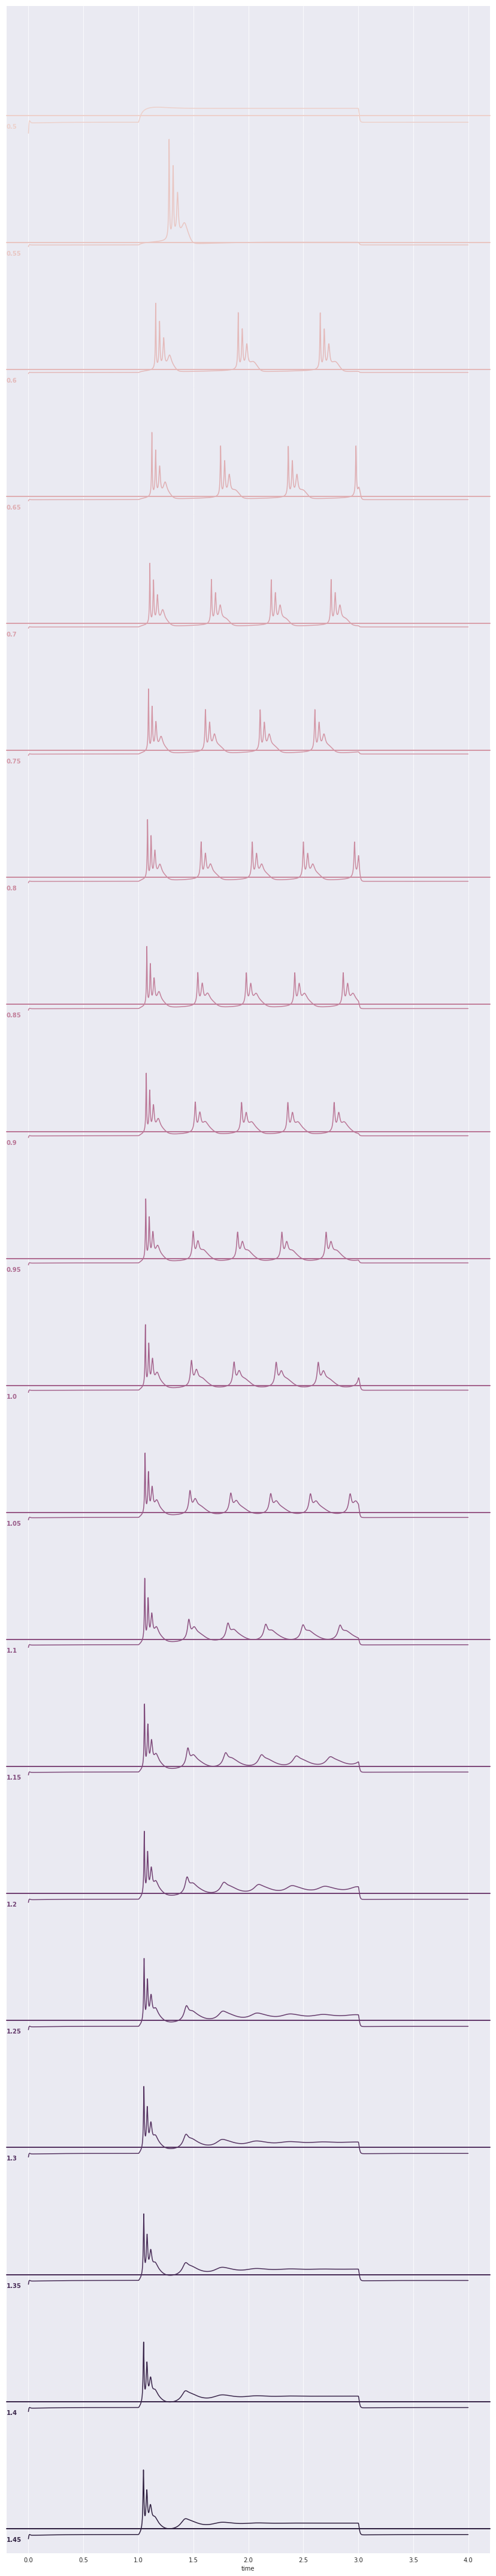

In [12]:
plot_timeseries(results, plot_style='ridge_plot', demean=True, aspect=4.0)

Next, we investigate the model dynamics for different levels of average background excitation $\eta$ with $\alpha = 3.0$, $\tau_a = 0.1$, $\Delta = 1.0$ and $J = 15.$.

**Sweep over $\eta$: Parameter definition:**

In [16]:
eta = np.round(np.arange(-10.0, 0., 0.5), decimals=2)
param_map = {'eta': {'var': [('Op_e_adapt.0', 'eta'), ('Op_i_adapt.0', 'eta')],
                     'nodes': ['E.0', 'I.0']}}

**Sweep over $\eta$: Simulation:**

In [17]:
results = grid_search(circuit_template="../config/cmc_templates.EI_adapt",
                      param_grid={'eta': eta}, param_map=param_map,
                      inputs={("E", "Op_e_adapt.0", "i_in"): input_constant, 
                              ("I", "Op_i_adapt.0", "i_in"): input_constant}, 
                      outputs={"r": ("E", "Op_e_adapt.0", "r")},
                      dt=dt, simulation_time=T, permute_grid=False, sampling_step_size=1e-3)

**Sweep over $\eta$: Visualization:**

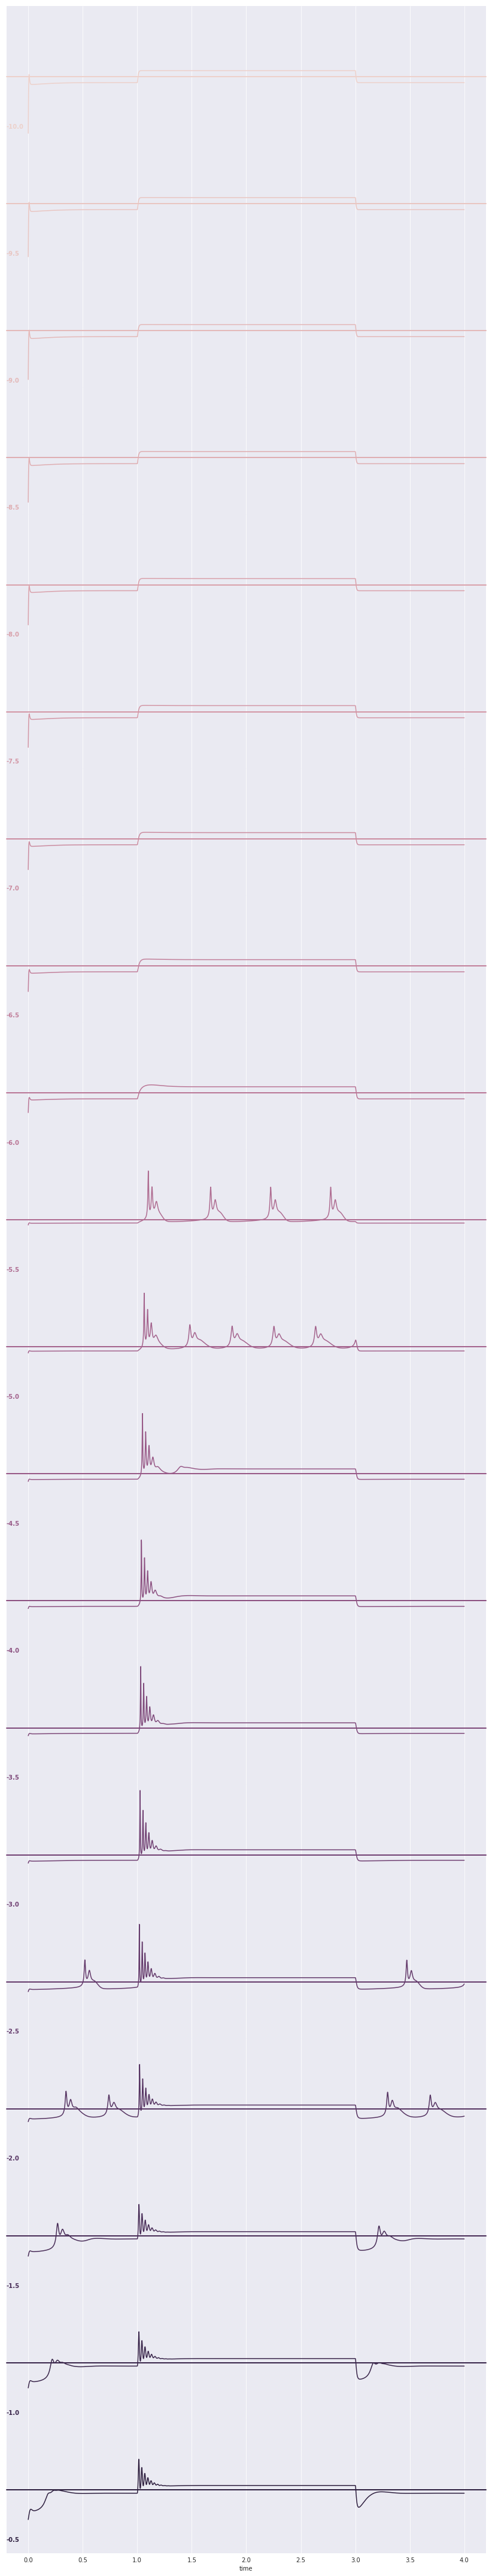

In [18]:
plot_timeseries(results, plot_style='ridge_plot', demean=True, aspect=4.0)

III: Adding synaptic dynamics to the Montbrio model
------------------------------------------------------------------------------

In a next step, we add synaptic dynamics to the model. For simplicity, we choose a simple exponentially rising and decaying model of the synaptic response $s$ to pre-synaptic firing rates $r$, given by:

$$\dot{s} = u$$

$$\dot{u} = \frac{\beta}{\tau_s} r - \frac{2u}{\tau_s} - \frac{s}{\tau^2}$$

where $\beta$ is a dimensionless scaling of the firing rate and $\tau_s$ the time-scale of the synapse.
Adding this mechanism to the extended Montbrio model, its evolution equations change to:

$$\dot{r} = \frac{\Delta}{\pi \tau^2} + \frac{2 r v}{\tau}$$

$$\dot{v} = \frac{v^2 + \overline{\eta} + I}{\tau} + (J_0 - J) s - \tau \pi^2 r^2$$

$$\dot{J} = a$$

$$\dot{a} = \frac{\alpha}{\tau_a} r - \frac{2a}{\tau_a} - \frac{J}{\tau_a^2}$$

$$\dot{s} = u$$

$$\dot{u} = \frac{\beta}{\tau_s} r - \frac{2u}{\tau_s} - \frac{s}{\tau_s^2}$$

Note, that in this set of equations, the adaptation term $J$ depends on $r$ instead of $s$. This corresponds to adaptation being triggered by pre-synaptic activity. We will consider the opposite case, where it is triggered by post-synaptic activity, in the next section.

First, however, we will investigate the model behavior for different choices of $\beta$ and $\tau_{s}$. We will start by looking at the raw firing rate dynamics for different choices of $\tau_{s}$ given $\beta = 160.0$, $\eta = -5.0$, $\alpha = 3.0$, $\tau_a = 0.1$, $\Delta = 1.0$ and $J = 15.$.

**Sweep over $\tau_s$: Parameter definition:**

In [13]:
tau_s = np.arange(0.001, 0.02, 0.001)
param_map = {'tau_s': {'var': [('Op_e.0', 'tau_s'), ('Op_i.0', 'tau_s')],
                       'nodes': ['E.0', 'I.0']}}

**Sweep over $\tau_s$: Simulation:**

In [4]:
results = grid_search(circuit_template="../config/cmc_templates.EI",
                      param_grid={'tau_s': tau_s}, param_map=param_map,
                      inputs={("E", "Op_e.0", "i_in"): input_constant, 
                              ("I", "Op_i.0", "i_in"): input_constant}, 
                      outputs={"r": ("E", "Op_e.0", "r")},
                      dt=dt, simulation_time=T, permute_grid=False, sampling_step_size=1e-3)

**Sweep over $\tau_s$: Visualization:**

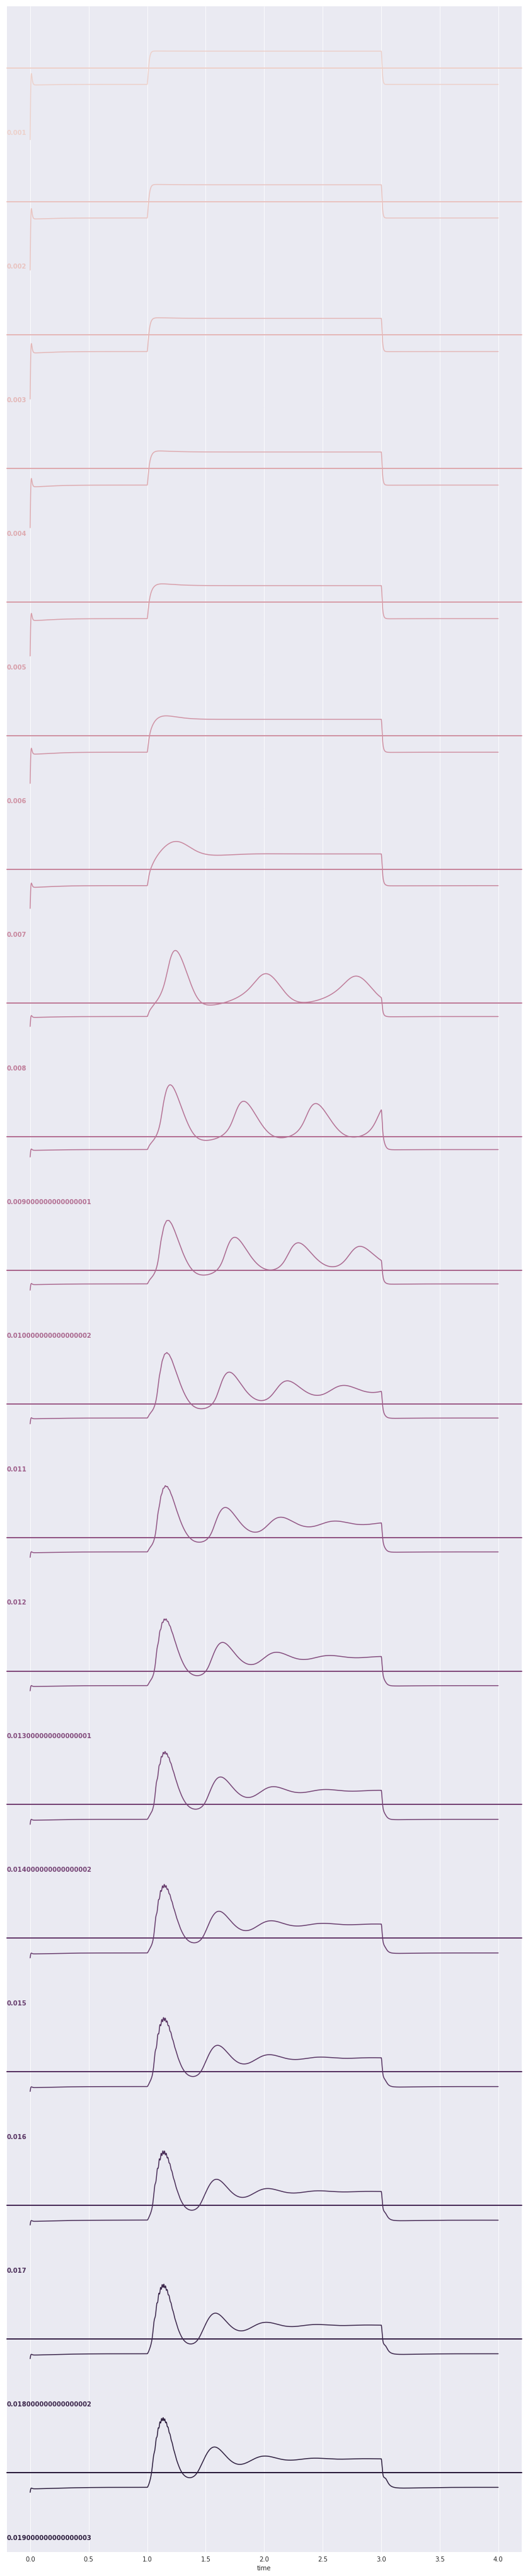

In [5]:
plot_timeseries(results, plot_style='ridge_plot', demean=True, aspect=4.0)

/home/rgast/PycharmProjects/PyRates/pyrates/utility/visualization.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['time'] = data.index


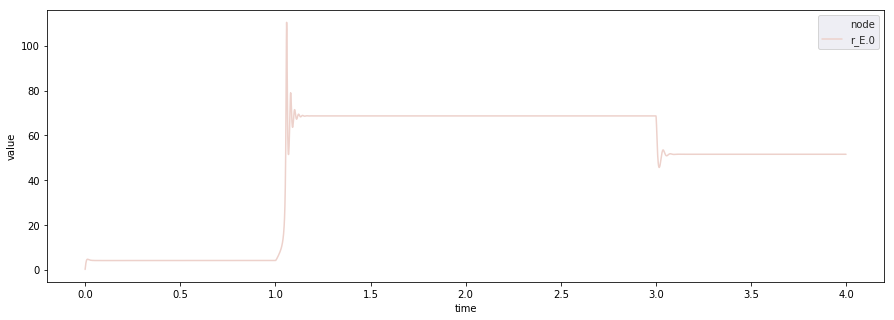

In [5]:
idx = 0
fig, ax = plt.subplots(figsize=(15,5))
plot_timeseries(results[tau[idx]], ax=ax)

Next, we look at the raw model dynamics for different choices of $\beta$ with $\tau_{s} = 0.01$, $\eta = -5.0$, $\alpha = 3.0$, $\tau_a = 0.1$, $\Delta = 1.0$ and $J = 15$.

**Sweep over $\beta$: Parameter definition:**

In [9]:
beta = np.arange(500., 2500., 100.)
param_map = {'beta': {'var': [('Op_e.0', 'beta'), ('Op_i.0', 'beta')],
                      'nodes': ['E.0', 'I.0']}}

**Sweep over $\beta$: Simulation:**

In [10]:
results = grid_search(circuit_template="../config/cmc_templates.EI",
                      param_grid={'beta': beta}, param_map=param_map,
                      inputs={("E", "Op_e.0", "i_in"): input_constant, 
                              ("I", "Op_i.0", "i_in"): input_constant}, 
                      outputs={"r": ("E", "Op_e.0", "r")},
                      dt=dt, simulation_time=T, permute_grid=False, sampling_step_size=1e-3)

**Sweep over $\beta$: Visualization:**

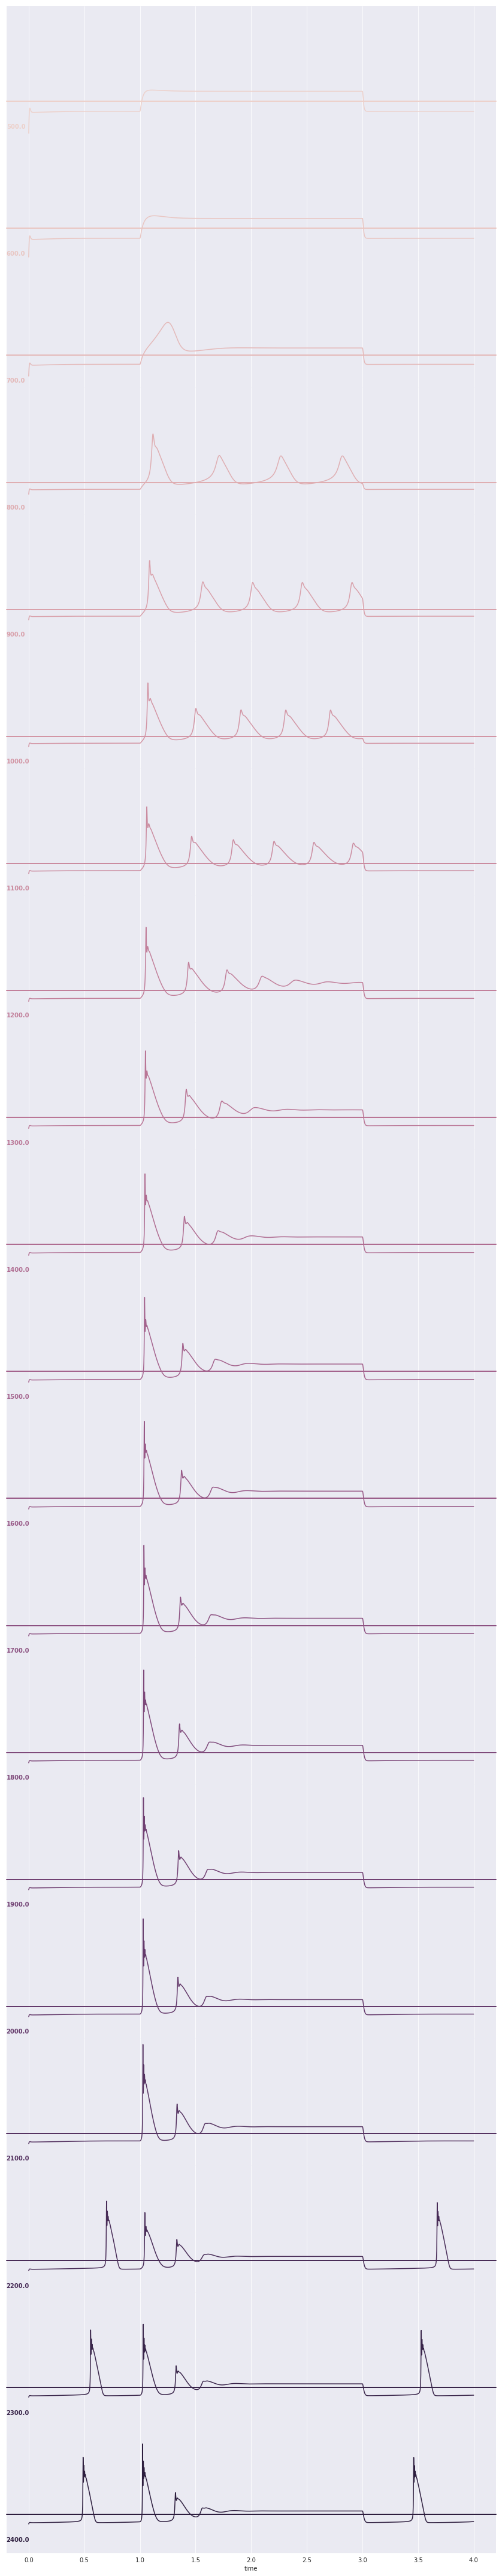

In [11]:
plot_timeseries(results, plot_style='ridge_plot', demean=True, aspect=4.0)

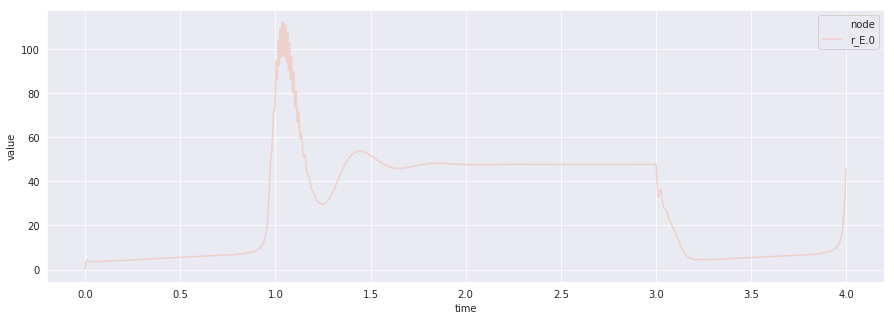

In [16]:
idx = 4
fig, ax = plt.subplots(figsize=(15,5))
plot_timeseries(results[beta[idx]], ax=ax)

Next, we investigate the model behavior for different choices of $\tau_{a}$ with $J = 15$, $\eta = -5$, $\Delta = 1.0$, $\tau_s = 0.001$, $\alpha = 3.0$ and $\beta = 1000.0$.

**Sweep over $\tau_{a}$ - Parameter definition:**

In [11]:
tau_a = np.round(np.arange(0.05, 1., 0.05), decimals=3)
param_map = {'tau_a': {'var': [('Op_e.0', 'tau_a'), ('Op_i.0', 'tau_a')],
                       'nodes': ['E.0', 'I.0']}}

**Sweep over $\tau_a$ - Simulation:**

In [12]:
results = grid_search(circuit_template="../config/cmc_templates.EI",
                      param_grid={'tau_a': tau_a}, param_map=param_map,
                      inputs={("E", "Op_e.0", "i_in"): input_constant, 
                              ("I", "Op_i.0", "i_in"): input_constant}, 
                      outputs={"r": ("I", "Op_i.0", "r")},
                      dt=dt, simulation_time=T, permute_grid=False, sampling_step_size=1e-3)

**Sweep over $\tau_a$ - Visualization:**

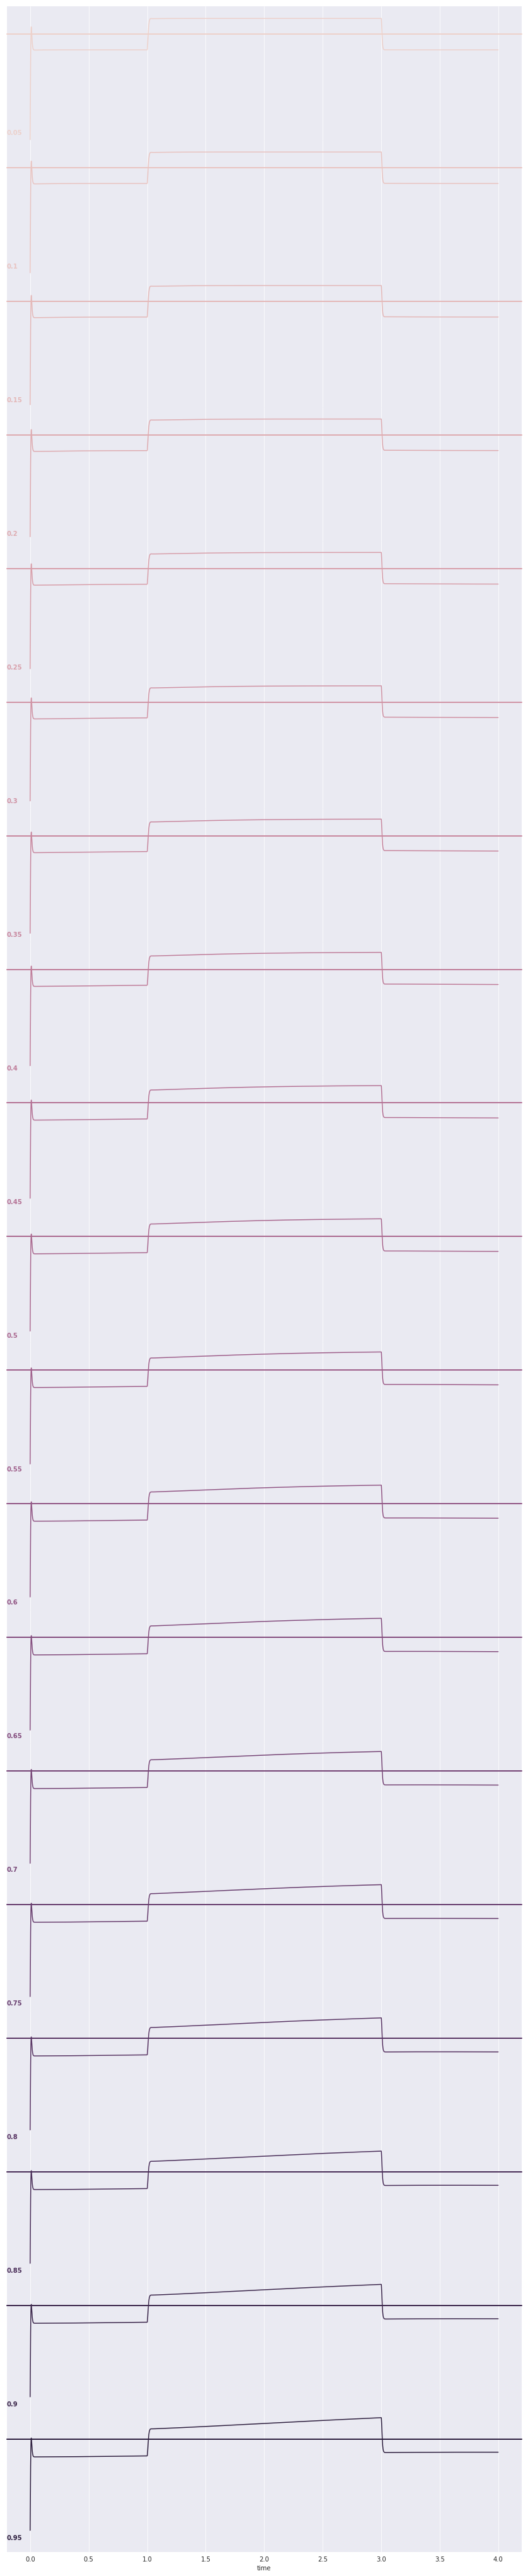

In [13]:
plot_timeseries(results, plot_style='ridge_plot', demean=True, aspect=4.0)

Next, we investigate the model behavior for different choices of $\alpha$ with $J = 15$, $\eta = -5$, $\Delta = 1.0$, $\tau_s = 0.001$, $\tau_{a} = 0.1$ and $\beta = 1000.0$.

**Sweep over $\alpha$ - Parameter definition:**

In [6]:
alpha = np.arange(0.5, 10., 0.5)
param_map = {'alpha': {'var': [('Op_e.0', 'alpha'), ('Op_i.0', 'alpha')],
                       'nodes': ['E.0', 'I.0']}}

**Sweep over $\alpha$ - Simulation:**

In [7]:
results = grid_search(circuit_template="../config/cmc_templates.EI",
                      param_grid={'alpha': alpha}, param_map=param_map,
                      inputs={("E", "Op_e.0", "i_in"): input_constant, 
                              ("I", "Op_i.0", "i_in"): input_constant}, 
                      outputs={"r": ("E", "Op_e.0", "r")},
                      dt=dt, simulation_time=T, permute_grid=False, sampling_step_size=1e-3)

**Sweep over $\alpha$ - Visualization:**

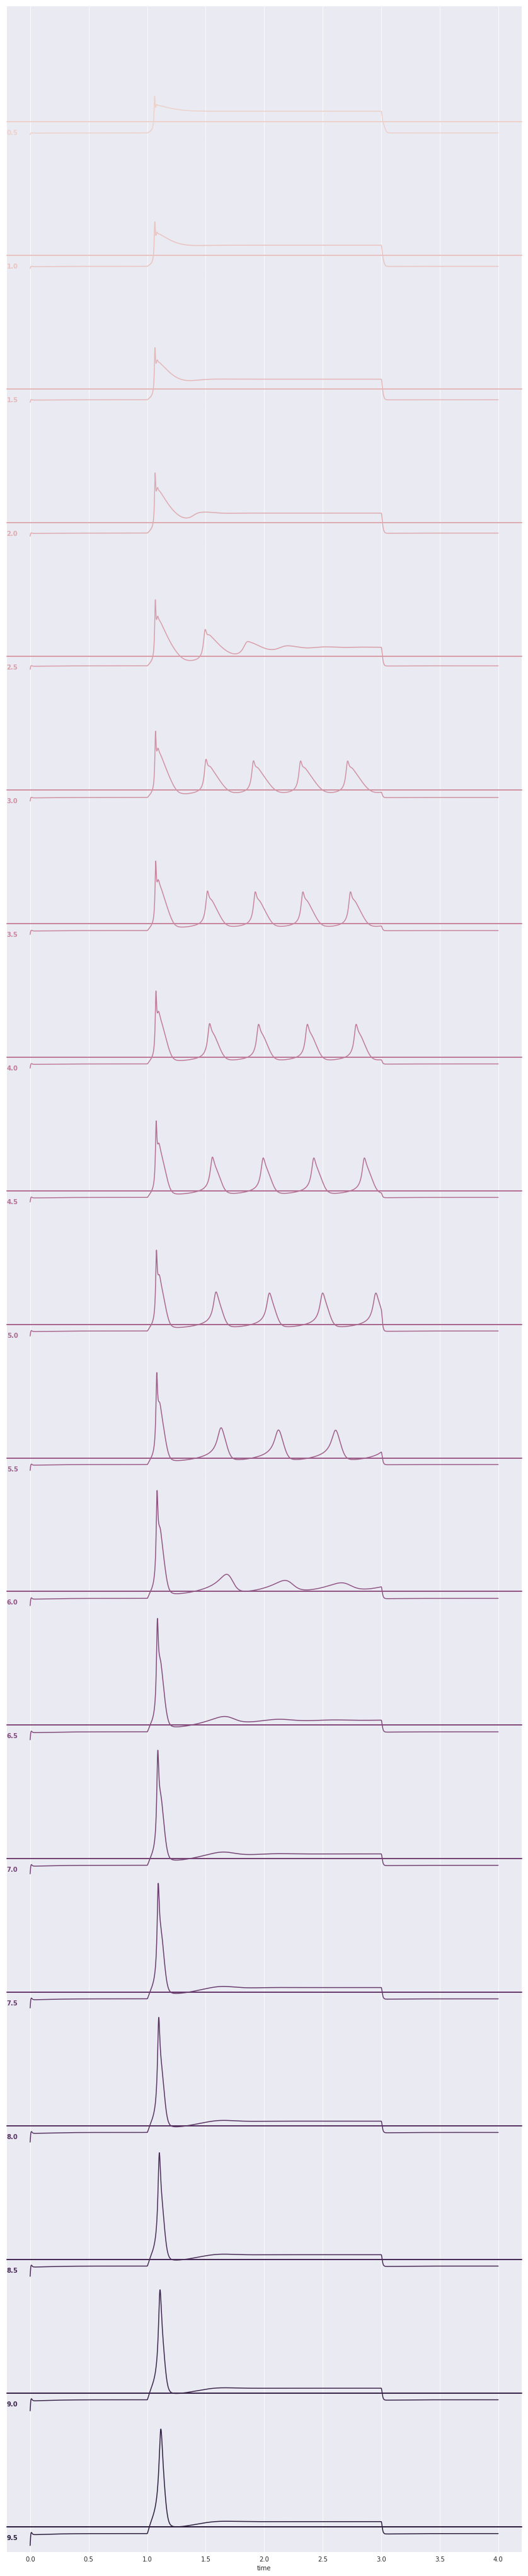

In [8]:
plot_timeseries(results, plot_style='ridge_plot', demean=True, aspect=4.0)

Next, we investigate the model behavior for different choices of $\eta$ with $J = 15$, $\Delta = 1.0$, $\tau_a = 0.1$, $\tau_s = 0.001$, $\alpha = 3.0$ and $\beta = 1000.0$.

**Sweep over $\eta$ - Parameter definition:**

In [9]:
eta = np.arange(-10., 1., 0.5)
param_map = {'eta': {'var': [('Op_e.0', 'eta'), ('Op_i.0', 'eta')],
                     'nodes': ['E.0', 'I.0']}}

**Sweep over $\eta$ - Simulation:**

In [10]:
results = grid_search(circuit_template="../config/cmc_templates.EI",
                      param_grid={'eta': eta}, param_map=param_map,
                      inputs={("E", "Op_e.0", "i_in"): input_constant, 
                              ("I", "Op_i.0", "i_in"): input_constant}, 
                      outputs={"r": ("E", "Op_e.0", "r")},
                      dt=dt, simulation_time=T, permute_grid=False, sampling_step_size=1e-3)

**Sweep over $\eta$ - Visualization:**

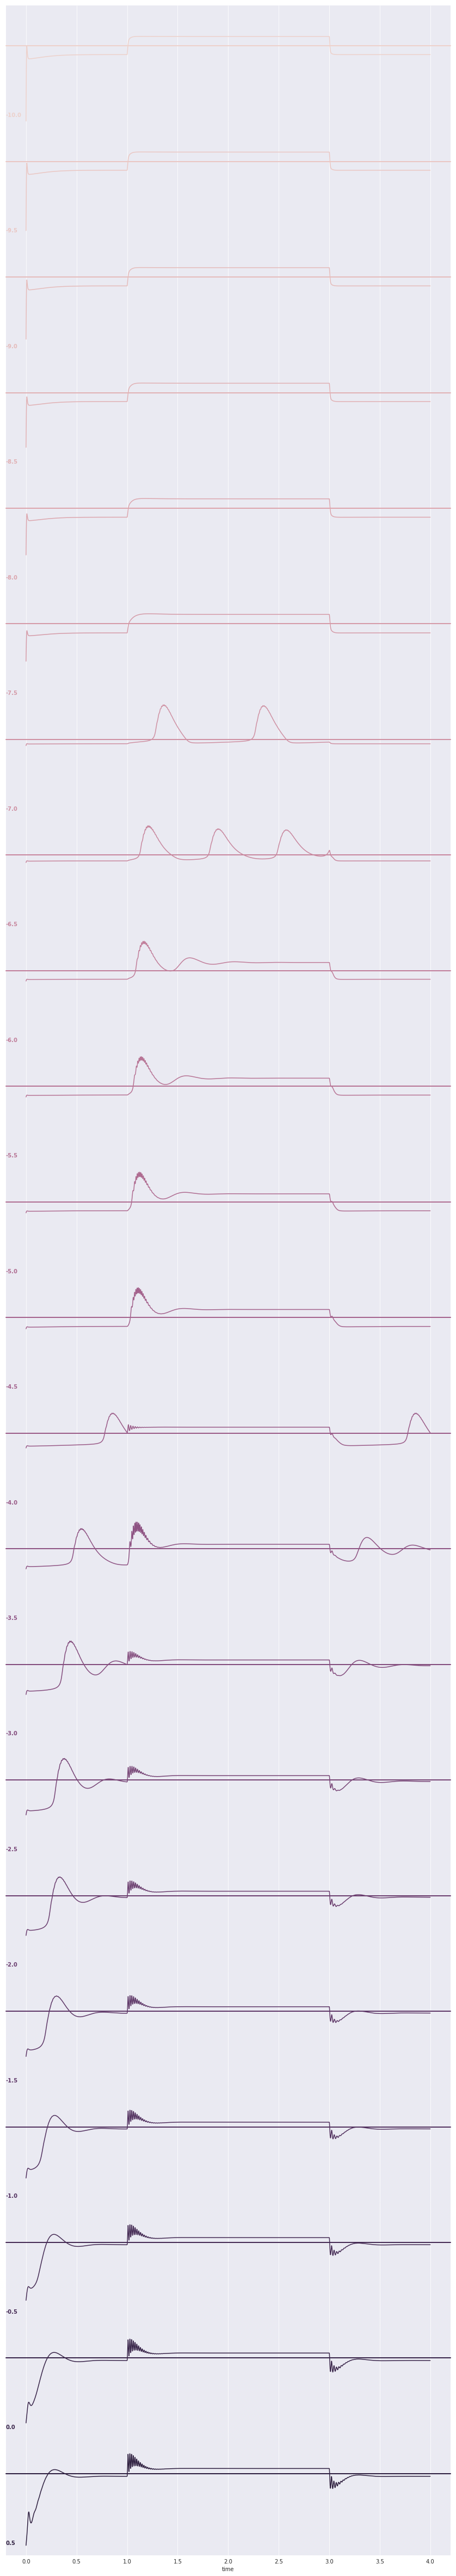

In [23]:
plot_timeseries(results, plot_style='ridge_plot', demean=True, aspect=4.0)

/home/rgast/PycharmProjects/PyRates/pyrates/utility/visualization.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['time'] = data.index


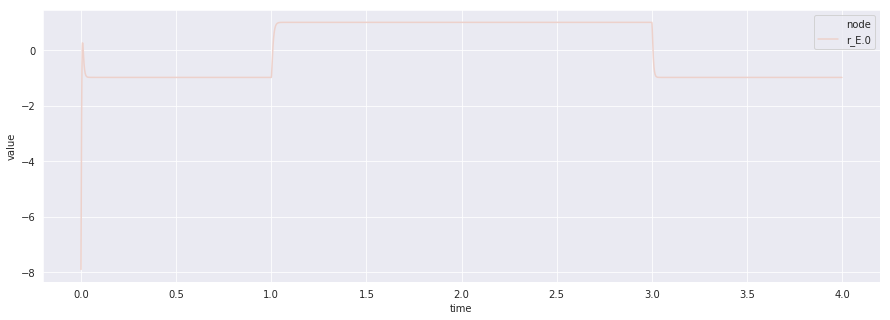

In [31]:
idx = 1
fig, ax = plt.subplots(figsize=(15,5))
plot_timeseries(results[eta[idx]], ax=ax)

Next, we investigate the model behavior for different choices of $J$ with $\eta = -5$, $\tau_a = 0.01$, $\tau_z = 0.001$, $\alpha = 0.1$ and $\beta = 1.0$.

**Sweep over $J$ - Parameter definition:**

In [15]:
J = np.round(np.arange(0., 31., 2.), decimals=0)
param_map = {'J': {'var': [('Op_e.0', 'J'), ('Op_i.0', 'J')],
                   'nodes': ['E.0', 'I.0']}}

**Sweep over $J$ - Simulation:**

In [16]:
results = grid_search(circuit_template="../config/cmc_templates.EI",
                      param_grid={'J': J}, param_map=param_map,
                      inputs={("E", "Op_e.0", "i_in"): input_constant, 
                              ("I", "Op_i.0", "i_in"): input_constant}, 
                      outputs={"r": ("E", "Op_e.0", "r")},
                      dt=dt, simulation_time=T, permute_grid=False, sampling_step_size=1e-3)

**Sweep over $J$ - Visualization:**

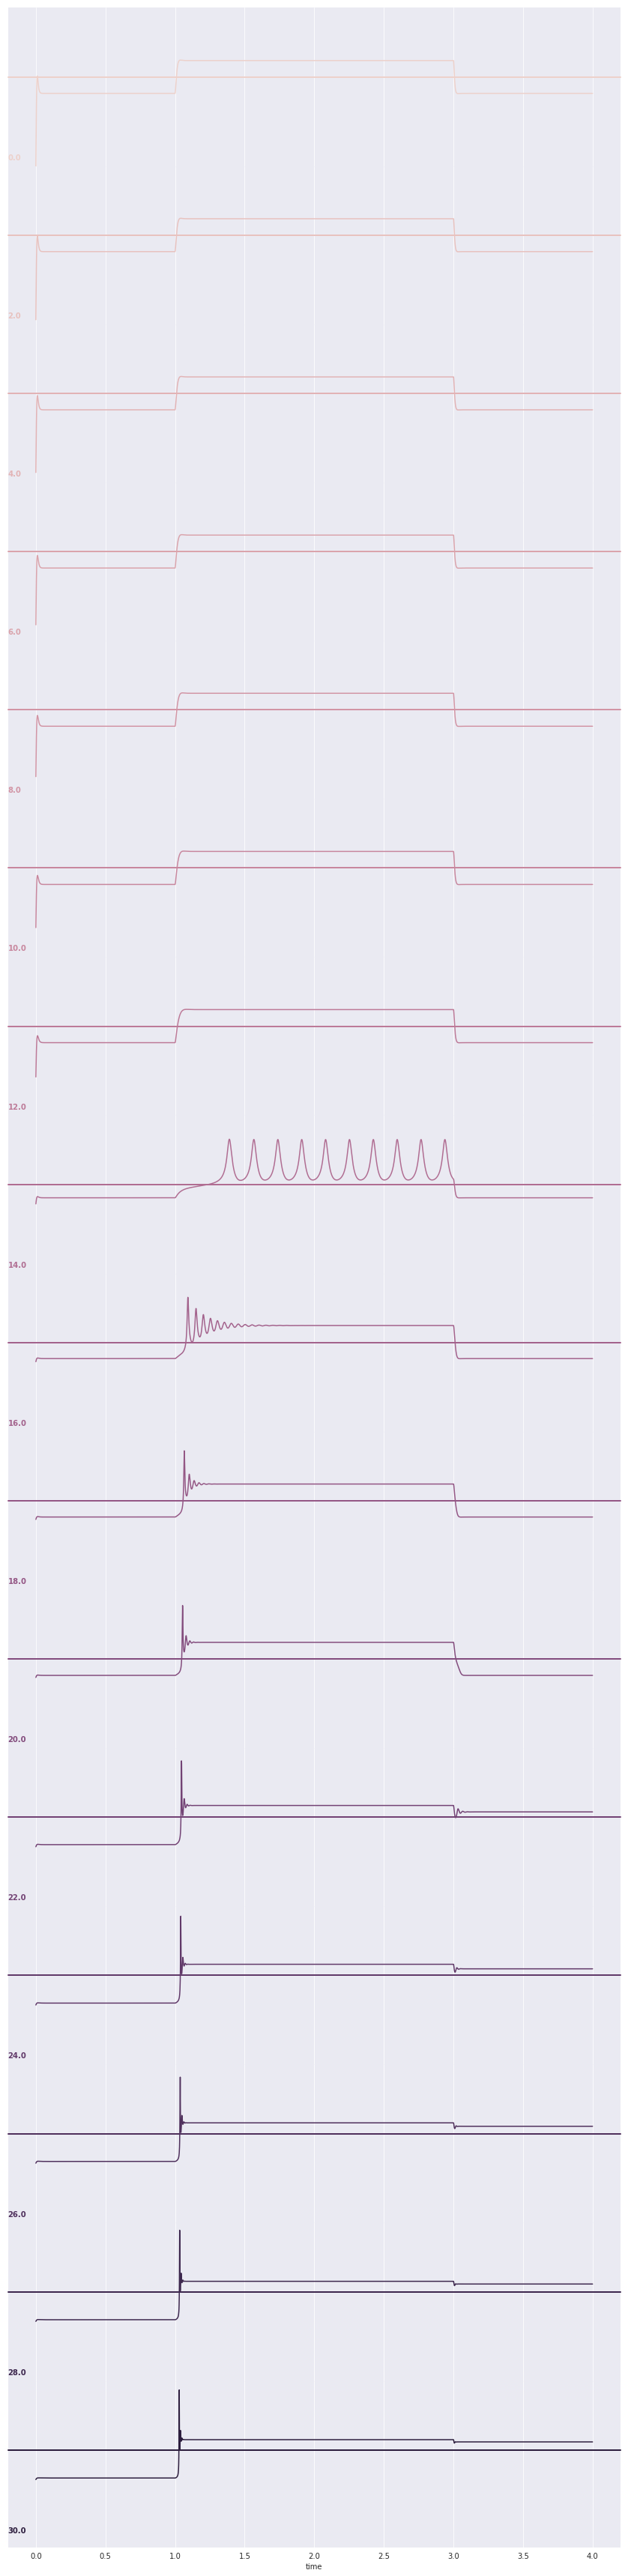

In [17]:
plot_timeseries(results, plot_style='ridge_plot', demean=True, aspect=4.0)

/home/rgast/PycharmProjects/PyRates/pyrates/utility/visualization.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['time'] = data.index


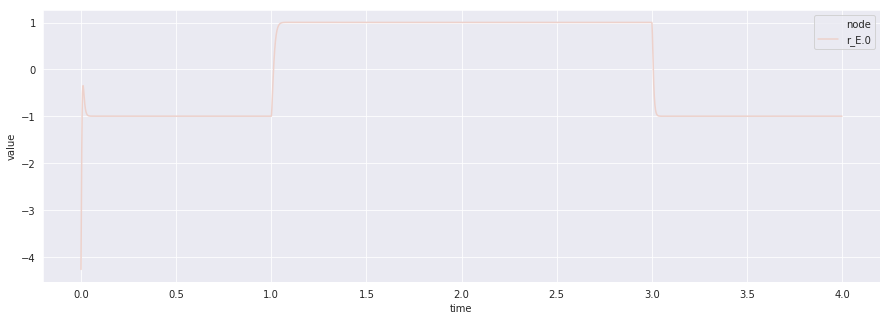

In [38]:
idx = 1
fig, ax = plt.subplots(figsize=(15,5))
plot_timeseries(results[J[idx]], ax=ax)

VI: Modeling adaptation depending on post-synaptic activity
-------------------------------------------------------------------------------------

Next, we will investigate the dependence between synaptic and adaptation dynamics in a model of synaptic adaptation that depends on post-synaptic activity. The evolution of a Montbrio population extended by such a mechanism is given by:

$$\dot{r} = \frac{\Delta}{\pi \tau^2} + \frac{2 r v}{\tau}$$

$$\dot{v} = \frac{v^2 + \overline{\eta} + I}{\tau} + (J_0 - J) s - \tau \pi^2 r^2$$

$$\dot{J} = a$$

$$\dot{a} = \frac{\alpha}{\tau_a} s - \frac{2a}{\tau_a} - \frac{J}{\tau_a^2}$$

$$\dot{s} = u$$

$$\dot{u} = \frac{\beta}{\tau_s} r - \frac{2u}{\tau_s} - \frac{s}{\tau_s^2}$$

where the only difference to the above described model is, that the adaptation depends on $s$ instead of $r$ now.

We will investigate the model behavior for different choices of $\tau_{a}$ given $\beta = 1000.0$, $\eta = -5.0$, $\alpha = 3.0$, $\tau_s = 0.001$, $\Delta = 1.0$ and $J = 15.$.

**Sweep over $\tau_a$: Parameter definition:**

In [4]:
tau_a = np.round(np.arange(0.05, 1., 0.05), decimals=3)
param_map = {'tau_a': {'var': [('Op_e.0', 'tau_a'), ('Op_i.0', 'tau_a')],
                       'nodes': ['E.0', 'I.0']}}

**Sweep over $\tau_a$ - Simulation:**

In [5]:
results = grid_search(circuit_template="../config/cmc_templates.EI",
                      param_grid={'tau_a': tau_a}, param_map=param_map,
                      inputs={("E", "Op_e.0", "i_in"): input_constant, 
                              ("I", "Op_i.0", "i_in"): input_constant}, 
                      outputs={"r": ("E", "Op_e.0", "r")},
                      dt=dt, simulation_time=T, permute_grid=False, sampling_step_size=1e-3)

**Sweep over $\tau_a$ - Visualization:**

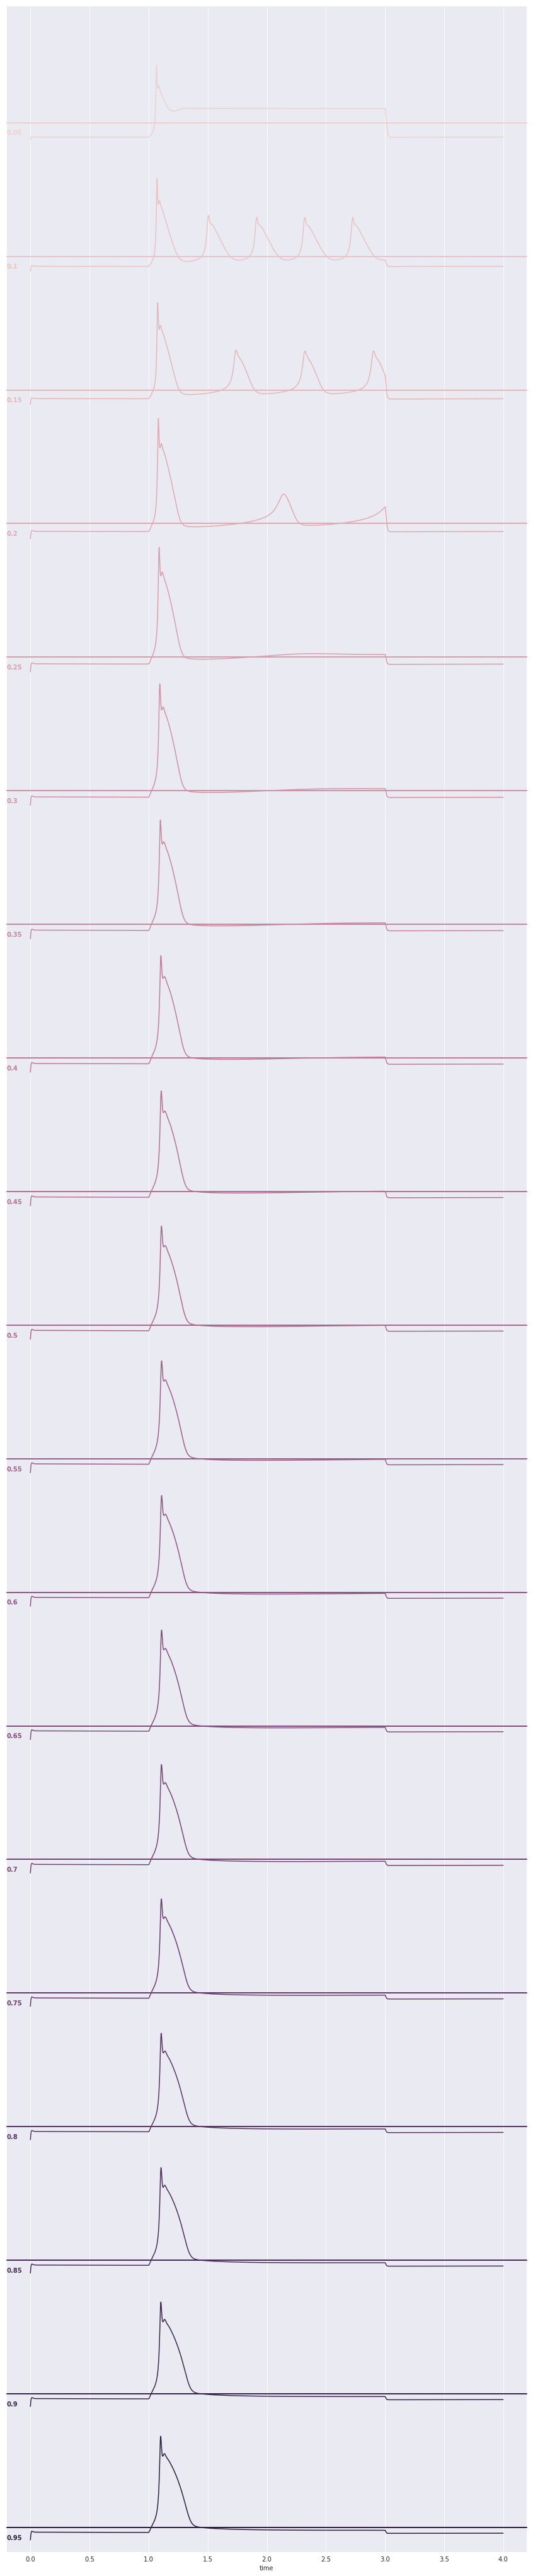

In [6]:
plot_timeseries(results, plot_style='ridge_plot', demean=True, aspect=4.0)

Next, we investigate the model behavior for different choices of $\alpha$ with $J = 15$, $\eta = -5$, $\Delta = 1.0$, $\tau_s = 0.001$, $\tau_{a} = 0.1$ and $\beta = 1000.0$.

**Sweep over $\alpha$ - Parameter definition:**

In [7]:
alpha = np.asarray([0.001, 0.01, 0.05, 0.1, 0.5, 1., 2., 3., 4., 5., 10.])
param_map = {'alpha': {'var': [('Op_e.0', 'alpha'), ('Op_i.0', 'alpha')],
                       'nodes': ['E.0', 'I.0']}}

**Sweep over $\alpha$ - Simulation:**

In [8]:
results = grid_search(circuit_template="../config/cmc_templates.EI",
                      param_grid={'alpha': alpha}, param_map=param_map,
                      inputs={("E", "Op_e.0", "i_in"): input_constant, 
                              ("I", "Op_i.0", "i_in"): input_constant}, 
                      outputs={"r": ("E", "Op_e.0", "r")},
                      dt=dt, simulation_time=T, permute_grid=False, sampling_step_size=1e-3)

**Sweep over $\alpha$ - Visualization:**

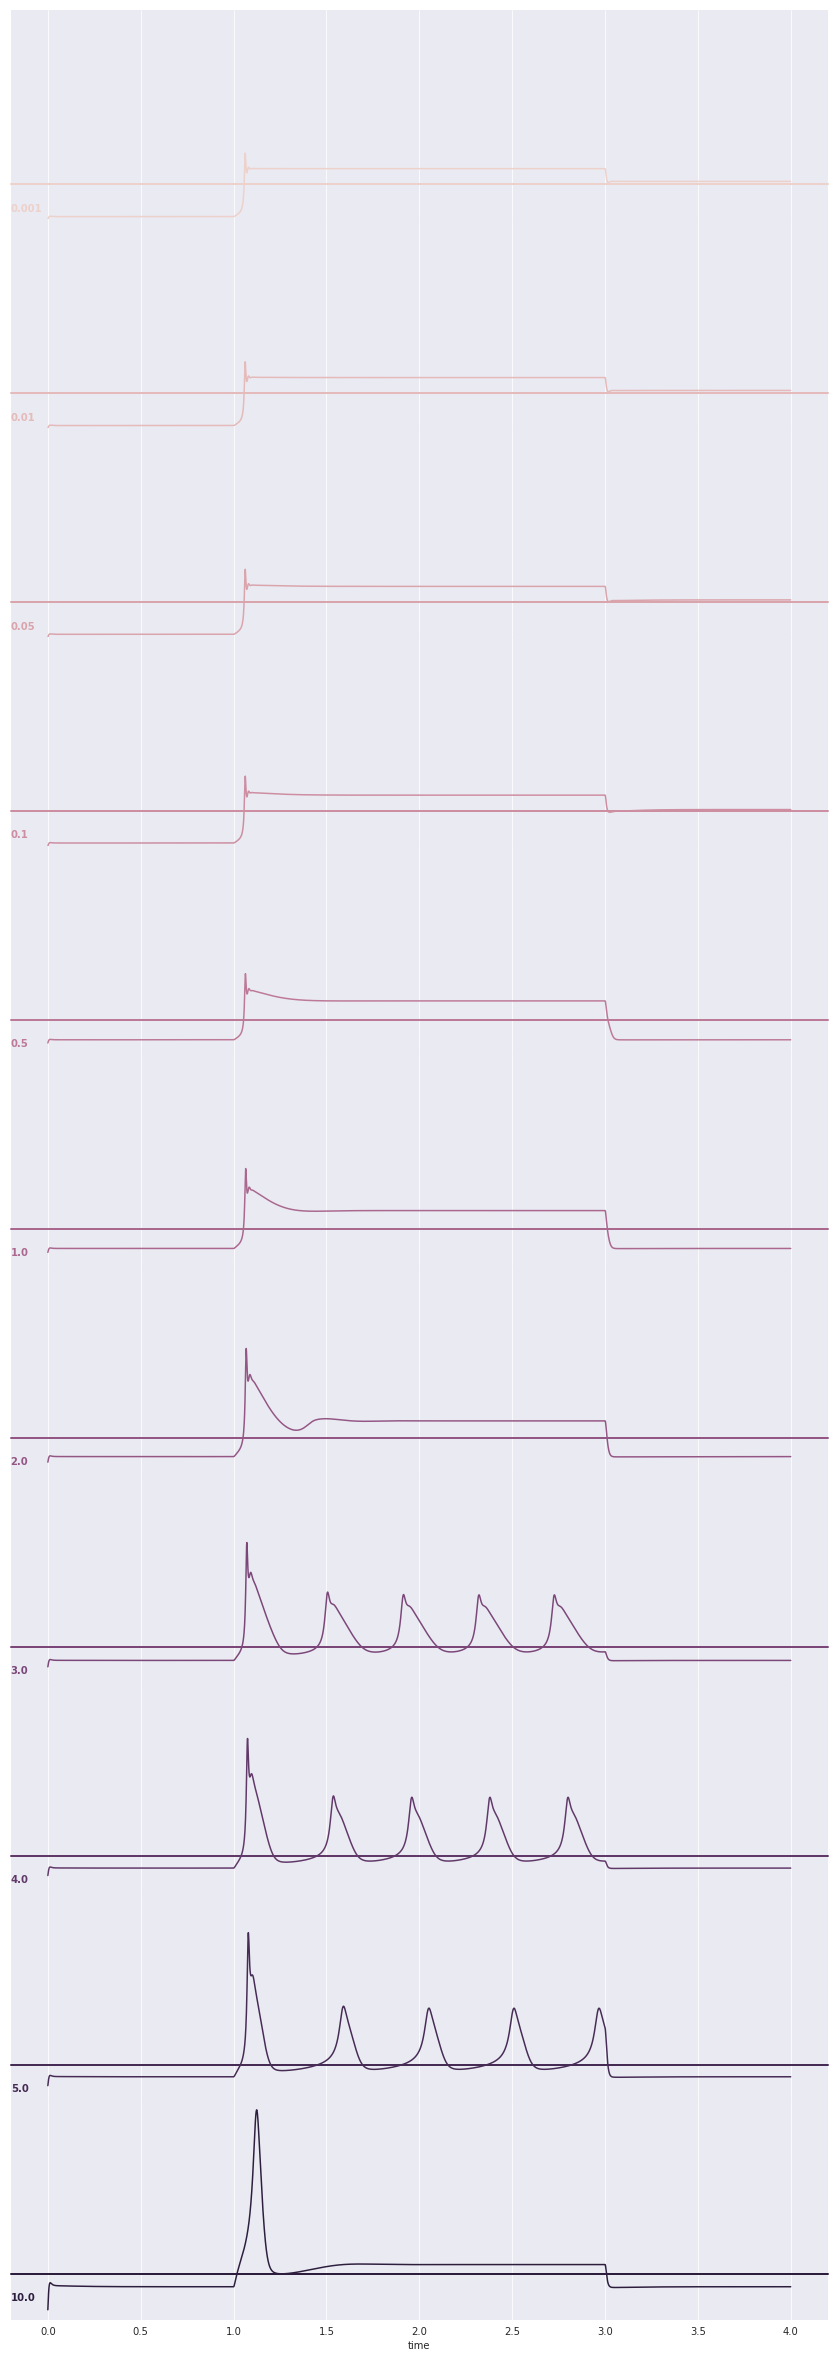

In [9]:
plot_timeseries(results, plot_style='ridge_plot', demean=True, aspect=4.0)

In [14]:
from pyrates.utility import plot_psd

plot_psd(results)

Creating RawArray with float64 data, n_channels=1, n_times=4000
    Range : 0 ... 3999 =      0.000 ...     3.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2845: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/rgast/PycharmProjects/PyRates/pyrates/utility/visualization.py:482: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=4000
    Range : 0 ... 3999 =      0.000 ...     3.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=4000
    Range : 0 ... 3999 =      0.000 ...     3.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2845: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/rgast/PycharmProjects/PyRates/pyrates/utility/visualization.py:482: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2845: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/rgast/PycharmProjects/PyRates/pyrates/utility/visualization.py:482: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=4000
    Range : 0 ... 3999 =      0.000 ...     3.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=4000
    Range : 0 ... 3999 =      0.000 ...     3.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2845: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/rgast/PycharmProjects/PyRates/pyrates/utility/visualization.py:482: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2845: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/rgast/PycharmProjects/PyRates/pyrates/utility/visualization.py:482: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=4000
    Range : 0 ... 3999 =      0.000 ...     3.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=4000
    Range : 0 ... 3999 =      0.000 ...     3.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2845: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/rgast/PycharmProjects/PyRates/pyrates/utility/visualization.py:482: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2845: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/rgast/PycharmProjects/PyRates/pyrates/utility/visualization.py:482: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=4000
    Range : 0 ... 3999 =      0.000 ...     3.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=4000
    Range : 0 ... 3999 =      0.000 ...     3.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2845: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/rgast/PycharmProjects/PyRates/pyrates/utility/visualization.py:482: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2845: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/rgast/PycharmProjects/PyRates/pyrates/utility/visualization.py:482: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=4000
    Range : 0 ... 3999 =      0.000 ...     3.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=4000
    Range : 0 ... 3999 =      0.000 ...     3.999 secs
Ready.


/home/rgast/Software/anaconda3/envs/pyrates/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2845: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/rgast/PycharmProjects/PyRates/pyrates/utility/visualization.py:482: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2845: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=4000
    Range : 0 ... 3999 =      0.000 ...     3.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=4000


/home/rgast/PycharmProjects/PyRates/pyrates/utility/visualization.py:482: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2845: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/rgast/PycharmProjects/PyRates/pyrates/utility/visualization.py:482: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2845: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


    Range : 0 ... 3999 =      0.000 ...     3.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=4000
    Range : 0 ... 3999 =      0.000 ...     3.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/PycharmProjects/PyRates/pyrates/utility/visualization.py:482: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2845: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/rgast/PycharmProjects/PyRates/pyrates/utility/visualization.py:482: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=4000
    Range : 0 ... 3999 =      0.000 ...     3.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=4000
    Range : 0 ... 3999 =      0.000 ...     3.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2845: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/rgast/PycharmProjects/PyRates/pyrates/utility/visualization.py:482: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2845: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/rgast/PycharmProjects/PyRates/pyrates/utility/visualization.py:482: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=4000
    Range : 0 ... 3999 =      0.000 ...     3.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=4000
    Range : 0 ... 3999 =      0.000 ...     3.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2845: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/rgast/PycharmProjects/PyRates/pyrates/utility/visualization.py:482: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2845: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/rgast/PycharmProjects/PyRates/pyrates/utility/visualization.py:482: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=4000
    Range : 0 ... 3999 =      0.000 ...     3.999 secs
Ready.
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2845: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/rgast/PycharmProjects/PyRates/pyrates/utility/visualization.py:482: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2845: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


TypeError: each entry in ch_names must be an instance of str, got <class 'float'> instead